<a href="https://colab.research.google.com/github/IanPuig/SCHOOL/blob/main/cnn_cifar10_tf2_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [1]:
import numpy as np
import time
import datetime
import random
import pandas as pd
import os

from matplotlib import pyplot as plt
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

## 2. Arquitectura de red del modelo


In [2]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform', input_shape=(32,32,3)))
model.add(ks.layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2))) 


model.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))
 

model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))


model.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))


model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.6))  


model.add(ks.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='he_uniform'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dropout(0.6))  

model.add(ks.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        2

Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

## 3. Optimizador, función error


In [3]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 4. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:** 
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [4]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

Obtenemos un array con todas las labels de CIFAR10

In [5]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


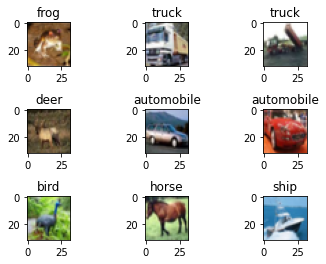

In [6]:
# Pintemos una muestra de las las imagenes del dataset MNIST

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [7]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución es pera una matriz de 4 campos** (más parecido a "imagenes"), no un array de 3 como son actualmente los data sets de train, test y validación. Así que toca darle al **.reshape()**

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [8]:
x_train_cnn = x_train.reshape((x_train.shape[0], 32, 32, 3))
x_test_cnn = x_test.reshape((x_test.shape[0], 32, 32, 3))
x_val_cnn = x_val.reshape((x_val.shape[0],32,32,3))

# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train_cnn.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_cnn.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val_cnn.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
Validation: X=(10000, 32, 32, 3), y=(10000, 1)


In [9]:

callback_val_loss = EarlyStopping(monitor="val_loss", patience=20)
callback_val_accy = EarlyStopping(monitor="val_accuracy", patience=20)

## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [10]:
t = time.perf_counter()

In [11]:
history = model.fit(x_train_cnn, y_train, epochs=200, use_multiprocessing=False, batch_size= 512, validation_data=(x_val, y_val), callbacks=[callback_val_loss, callback_val_accy])

Epoch 1/200
79/79 [==============================] - 9s 66ms/step - loss: 5.4712 - accuracy: 0.1820 - val_loss: 5.2947 - val_accuracy: 0.1736
Epoch 2/200
79/79 [==============================] - 4s 55ms/step - loss: 4.2425 - accuracy: 0.3390 - val_loss: 5.8452 - val_accuracy: 0.2006
Epoch 3/200
79/79 [==============================] - 4s 55ms/step - loss: 3.7438 - accuracy: 0.4269 - val_loss: 4.7524 - val_accuracy: 0.2148
Epoch 4/200
79/79 [==============================] - 4s 55ms/step - loss: 3.3195 - accuracy: 0.5161 - val_loss: 3.7089 - val_accuracy: 0.3622
Epoch 5/200
79/79 [==============================] - 4s 55ms/step - loss: 2.9529 - accuracy: 0.5882 - val_loss: 3.5296 - val_accuracy: 0.3990
Epoch 6/200
79/79 [==============================] - 4s 57ms/step - loss: 2.6445 - accuracy: 0.6417 - val_loss: 3.0692 - val_accuracy: 0.4765
Epoch 7/200
79/79 [==============================] - 4s 56ms/step - loss: 2.3971 - accuracy: 0.6765 - val_loss: 2.7704 - val_accuracy: 0.5346
Epoch 

In [12]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:02:52.912334


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [13]:
_, acc = model.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 74.480


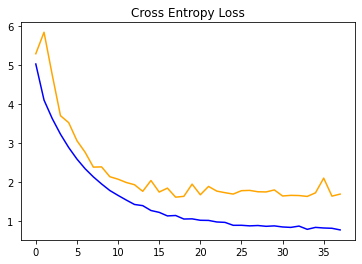

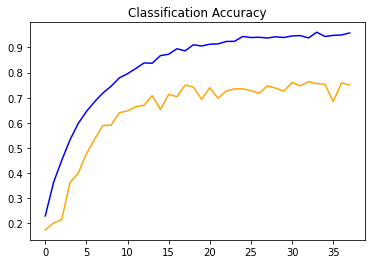

In [14]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [15]:
predictions = model.predict(x_test_cnn)

Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [16]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


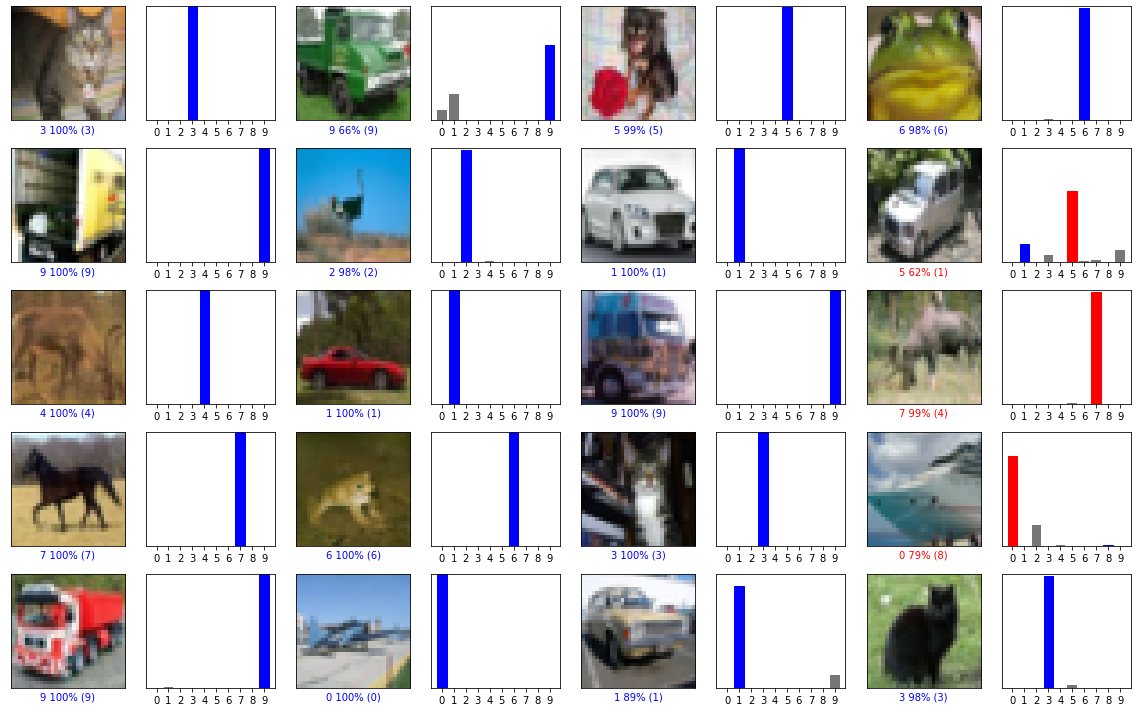

In [17]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()